# Wind Energy Forecasting: Data Story
The dataset chosen for this exercise is provided by Institute of Electrical and Electronics Engineers (IEEE), Power & Energy Society, and retrieved through the Kaggle database (https://www.kaggle.com/c/GEF2012-wind-forecasting).  The dataset is a time series dataset with historical power generation, wind speeds and wind directions, for the time period from July 2009 to December 2010. 

#### Importing Packages and Defining Custom Functions for Data Cleaning

In [1]:
# Import packages for data visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Custom Functions
def convert_to_iso(date_col):
    """
    Convert a date, originally in format YYYYMMDDHH,
    to ISO 8601 format (https://en.wikipedia.org/wiki/ISO_8601)
    
    Input: an array of DateTimes in YYYYMMDD format
    Output: an array of DateTimes in ISO 8601 format
    """
    date_col = date_col.astype(str)
    
    # year = YYYY
    year = date_col.str[0:4]
    # month = MM
    month = date_col.str[4:6]
    # day = DD
    day = date_col.str[6:8]
    # hour = HH
    hour = date_col.str[8:10]
    date_iso8601 = pd.to_datetime(year + '-' + month + '-' + day + 'T' + hour + ':00:00')
    
    return date_iso8601

def add_forecast_cat(wfn):
    """
    Add a forecast category column to the Wind Farm data
    Forecast Category 1:  1-12 hour forecasts
    Forecast Category 2: 13-24 hour forecasts
    Forecast Category 3: 25-36 hour forecasts
    Forecast Category 4: 37-48 hour forecasts
    
    Input: A DataFrame of Wind Farm data with column 'hors' containing hour-ahead forecasts 
    Output: The same DataFrame with an added column, 'forecast_cat' containing the forecast category
    """
    
    wfn['forecast_cat'] = None
    wfn.loc[ (wfn['hors'] >= 1) & (wfn['hors'] <= 12), 'forecast_cat'] = 1
    wfn.loc[ (wfn['hors'] >= 13) & (wfn['hors'] <= 24), 'forecast_cat'] = 2
    wfn.loc[ (wfn['hors'] >= 25) & (wfn['hors'] <= 36), 'forecast_cat'] = 3
    wfn.loc[ (wfn['hors'] >= 37) & (wfn['hors'] <= 48), 'forecast_cat'] = 4

    return wfn

def wfn_by_fc(wfn, forecast_cat):
    """
    Take a windfarm DataFrame and return a boolean sliced 
    version including data for a given forecast category
    
    Input: A DataFrame of Wind Farm data
    Output: The same DataFrame, but including only data for the requested forecast category
    """

    wfn = wfn.loc[(wfn['forecast_cat'] == forecast_cat)] # row slice
    return wfn

#### Importing Wind Speed and Direction Data

In [3]:
# Import wind speed and wind direction data for each wind farm, "wind farm data"
wf_dict = {'wf1': pd.read_csv('windforecasts_wf1.csv'), # Wind Farm 1
           'wf2': pd.read_csv('windforecasts_wf2.csv'), # Wind Farm 2
           'wf3': pd.read_csv('windforecasts_wf3.csv'), # Wind Farm 3
           'wf4': pd.read_csv('windforecasts_wf4.csv'), # Wind Farm 4
           'wf5': pd.read_csv('windforecasts_wf5.csv'), # Wind Farm 5
           'wf6': pd.read_csv('windforecasts_wf6.csv'), # Wind Farm 6
           'wf7': pd.read_csv('windforecasts_wf7.csv')} # Wind Farm 7

#### Importing Power Data

Note: we include only 2009-2010 data because these are the years for which there is complete data (i.e. wind speed, wind direction, and wind power data for every DateTime).

In [4]:
# Import wind power data
power = pd.read_csv('train.csv')

# Convert DateTimes to ISO 8601 format for standardization
power['date'] = convert_to_iso(power['date']) 

# Include only 2009-2010 data for wind power data
power = power.loc[ (power['date'] >= '2009-07-01') & 
                   (power['date'] <=  '2010-12-31')]

# Set index for wind power data
power.set_index('date', inplace=True)   

In [5]:
# Dictionary with wind farm data as keys and wind power data as values
wp_lookup = {'wf1':'wp1',
             'wf2':'wp2',
             'wf3':'wp3',
             'wf4':'wp4',
             'wf5':'wp5', 
             'wf6':'wp6',
             'wf7':'wp7'}

#### Cleaning Wind Speed & Direction Data, Merging with Wind Power Data
Note: we include only 2009-2010 data because these are the years for which there is complete data (i.e. wind speed, wind direction, and wind power data for every DateTime).

In [6]:
for key, _ in wf_dict.items():
    
    # Convert date-times to ISO 8601 format for standardization
    wf_dict[key]['date'] = convert_to_iso(wf_dict[key]['date'])
    # Initialize mod_date column
    wf_dict[key]['mod_date'] = (wf_dict[key]['date'] + 
                                pd.to_timedelta(arg=wf_dict[key]['hors'],unit='h'))
    # Initialize forecast_cat column
    wf_dict[key] = add_forecast_cat(wf_dict[key])

    # Include only 2009-2010 data for wind speed/direction data
    wf_dict[key] = wf_dict[key].loc[(wf_dict[key]['mod_date'] >= '2009-07-01') & 
                                    (wf_dict[key]['mod_date'] <= '2010-12-31')]
    # Set Index column
    wf_dict[key].set_index('mod_date',inplace=True)
    
    # Merge wind speed/direction data with wind power data
    wf_dict[key] = wf_dict[key].merge(power[[wp_lookup[key]]], 
                                      how='left',
                                      left_index=True,       
                                      right_index=True)

In [7]:
# Explore wind farm data
print(wf_dict['wf1'].head(15))

                                   date  hors     u     v    ws      wd  \
2009-07-01 01:00:00 2009-07-01 00:00:00     1  2.34 -0.79  2.47  108.68   
2009-07-01 02:00:00 2009-07-01 00:00:00     2  2.18 -0.99  2.40  114.31   
2009-07-01 03:00:00 2009-07-01 00:00:00     3  2.20 -1.21  2.51  118.71   
2009-07-01 04:00:00 2009-07-01 00:00:00     4  2.35 -1.40  2.73  120.86   
2009-07-01 05:00:00 2009-07-01 00:00:00     5  2.53 -1.47  2.93  120.13   
2009-07-01 06:00:00 2009-07-01 00:00:00     6  2.66 -1.29  2.96  115.79   
2009-07-01 07:00:00 2009-07-01 00:00:00     7  2.69 -0.81  2.81  106.71   
2009-07-01 08:00:00 2009-07-01 00:00:00     8  2.72 -0.26  2.73   95.39   
2009-07-01 09:00:00 2009-07-01 00:00:00     9  2.87  0.08  2.87   88.50   
2009-07-01 10:00:00 2009-07-01 00:00:00    10  3.23 -0.01  3.23   90.19   
2009-07-01 11:00:00 2009-07-01 00:00:00    11  3.65 -0.33  3.66   95.15   
2009-07-01 12:00:00 2009-07-01 00:00:00    12  3.89 -0.60  3.94   98.71   
2009-07-01 13:00:00 2009-

NOTE: All data is unitless.
**Description:** Index is dates in ISO-8601 DateTime format. 'date' column data is unformatted DateTime data. 'hors' column data is unformatted hour data, representing the number of hours-ahead being forecasted at the corresponding DateTime. 'u' is magnitude of x-axis wind speed vector. 'v' is magnitude of y-axis wind speed vector. 'ws' is magnitude of wind speed. 'wd' is angle of wind direction. 'forecast_cat' is forecast category, ranging from 1-4.
'wp(n)' column represents wind power data where n=1...7 represent each of the seven wind farms.

### Exploratory Data Analysis

##### Average Wind Speed, Direction and Power Production for all Wind Farms

In [8]:
# Mean Wind Speeds at each Wind Farm
mean_ws = [] # Initialize list of mean wind speeds
for key, _ in wf_dict.items():
    print('Mean Wind Speed at Wind Farm (', key, '): ', np.mean(wf_dict[key]['ws']))
    mean_ws.append(np.mean(wf_dict[key]['ws']))
print('Mean Wind Speed across all Wind Farms: ', np.mean(mean_ws))

Mean Wind Speed at Wind Farm ( wf1 ):  4.093920740063928
Mean Wind Speed at Wind Farm ( wf2 ):  3.983017169179244
Mean Wind Speed at Wind Farm ( wf3 ):  4.641460141617201
Mean Wind Speed at Wind Farm ( wf4 ):  4.523693848028032
Mean Wind Speed at Wind Farm ( wf5 ):  4.4750428277752325
Mean Wind Speed at Wind Farm ( wf6 ):  5.021111809045259
Mean Wind Speed at Wind Farm ( wf7 ):  5.552922377036726
Mean Wind Speed across all Wind Farms:  4.61302413039


The mean wind speed ranges from 3.98 to 5.55.  The mean wind speed across all wind farms is 4.61.

In [9]:
# Mean Wind Direction at each Wind Farm
mean_wd = [] # Initialize list of mean wind directions
for key, _ in wf_dict.items():
    print('Mean Wind Direction at Wind Farm (', key, '): ', np.mean(wf_dict[key]['wd']))
    mean_wd.append(np.mean(wf_dict[key]['wd']))
print('Mean Wind Direction across all Wind Farms: ', np.mean(mean_wd))

Mean Wind Direction at Wind Farm ( wf1 ):  145.7365256205278
Mean Wind Direction at Wind Farm ( wf2 ):  177.4848488655396
Mean Wind Direction at Wind Farm ( wf3 ):  154.0302607735651
Mean Wind Direction at Wind Farm ( wf4 ):  154.20988712501904
Mean Wind Direction at Wind Farm ( wf5 ):  142.7017047358013
Mean Wind Direction at Wind Farm ( wf6 ):  156.74560872544816
Mean Wind Direction at Wind Farm ( wf7 ):  158.92289268311256
Mean Wind Direction across all Wind Farms:  155.690246933


The mean angle of wind direction ranges from 142.70 to 177.49. The mean angle of wind direction across all wind farms is 155.69

In [10]:
# Mean Wind Power Production at each Wind Farm
mean_wp = [] # Initialize list of mean wind power
for key, _ in wf_dict.items():
    print('Mean Wind Power at Wind Farm (', key, '): ', np.mean(wf_dict[key][wp_lookup[key]]))
    mean_wp.append(np.mean(wf_dict[key][wp_lookup[key]]))
print('Mean Wind Power across all Wind Farms: ', np.mean(mean_wp))

Mean Wind Power at Wind Farm ( wf1 ):  0.24173283082076238
Mean Wind Power at Wind Farm ( wf2 ):  0.26198631414647794
Mean Wind Power at Wind Farm ( wf3 ):  0.32530183112536704
Mean Wind Power at Wind Farm ( wf4 ):  0.2754647099132043
Mean Wind Power at Wind Farm ( wf5 ):  0.25795926602710356
Mean Wind Power at Wind Farm ( wf6 ):  0.2719464367291193
Mean Wind Power at Wind Farm ( wf7 ):  0.28367283386626524
Mean Wind Power across all Wind Farms:  0.274009174661


The mean wind power ranges from 0.24 to 0.28. The mean wind power across all wind farms is 0.27

##### Visualizing Wind Speeds at Wind Farm 1, July 8-15 2009

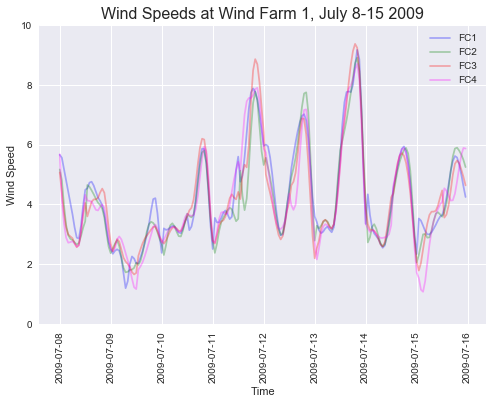

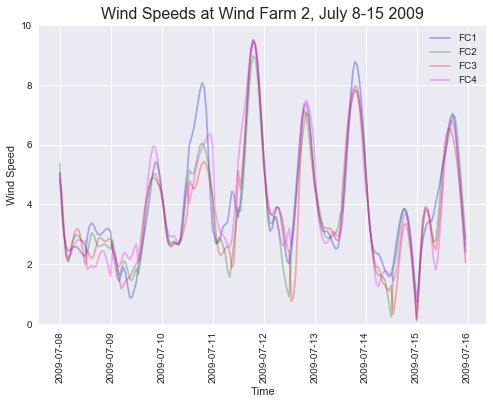

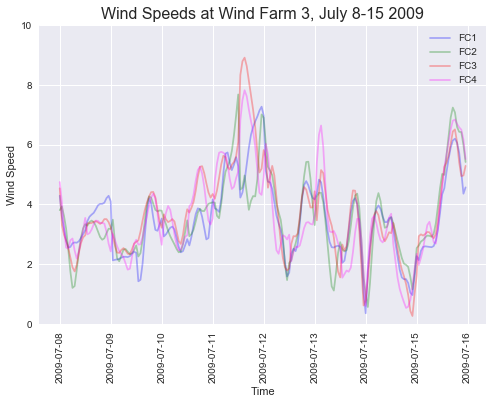

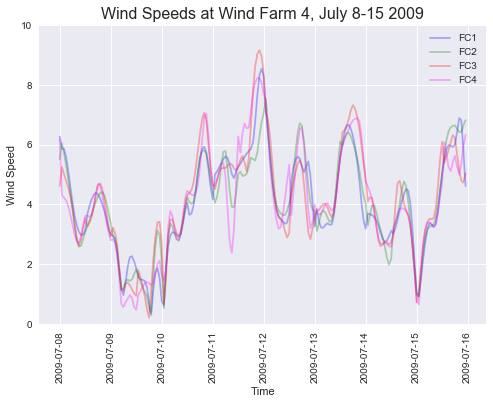

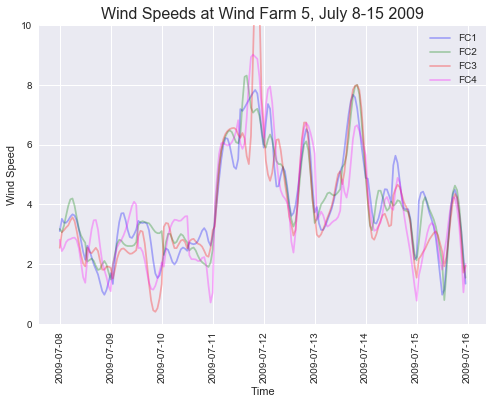

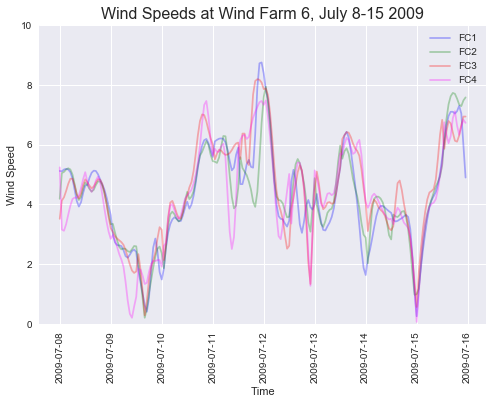

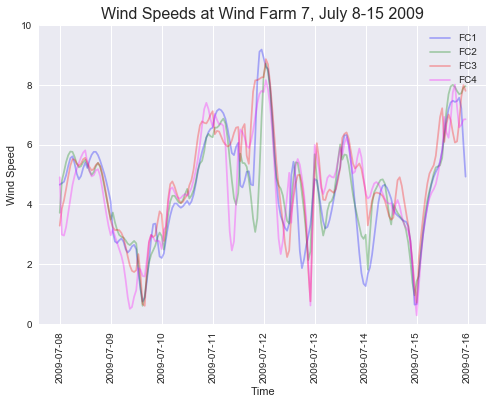

In [11]:
counter = int()
for key, _ in wf_dict.items():
    
    counter += 1
    fc1 = wfn_by_fc(wf_dict[key],1)
    fc2 = wfn_by_fc(wf_dict[key],2)
    fc3 = wfn_by_fc(wf_dict[key],3)
    fc4 = wfn_by_fc(wf_dict[key],4)
    
    plt.figure()
    plt.plot(fc1['ws']['July 8, 2009':'July 15, 2009'], color='blue', label='FC1', alpha=0.3)
    plt.plot(fc2['ws']['July 8, 2009':'July 15, 2009'], color='green', label='FC2', alpha=0.3)
    plt.plot(fc3['ws']['July 8, 2009':'July 15, 2009'], color='red', label='FC3', alpha=0.3)
    plt.plot(fc4['ws']['July 8, 2009':'July 15, 2009'], color='magenta', label='FC4', alpha=0.3)
    plt.legend(loc='upper right') 
    plt.ylim([0,10])
    plt.xlabel('Time')
    plt.xticks(rotation='vertical')
    plt.ylabel('Wind Speed')
    plt.title('Wind Speeds at Wind Farm ' + str(counter) + ', July 8-15 2009', fontsize=16)
    
    plt.show()

**** Question: Do wind speeds at each wind farm exhibit any daily patterns? ****

Plotting wind speed over the course of one week for each wind farm suggests that wind speeds tend to follow a diurnal curve with lower wind speeds at night and higher wind speeds in the afternoon to early evening.  

##### Visualizing Wind Speeds at Wind Farm 1, Box Plot

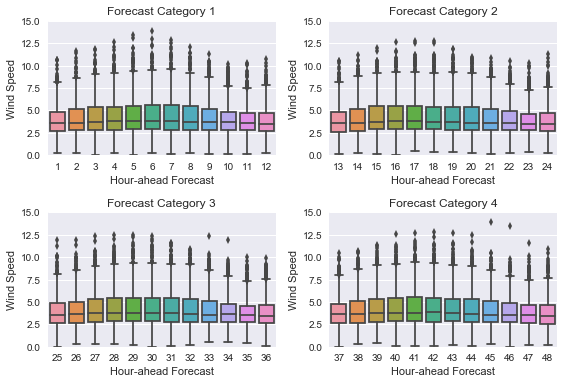

In [12]:
for i in range(1,5):
    plt.subplot(2,2,i)
    sns.boxplot(x='hors', y='ws', data=wfn_by_fc(wf_dict['wf1'],i))
    plt.ylim([0,15])
    plt.title('Forecast Category ' + str(i))
    plt.xlabel('Hour-ahead Forecast')
    plt.ylabel('Wind Speed')

plt.tight_layout()
plt.show()

**** Question: Is there a difference in wind speeds from different forecast categories? ****

A visual comparison of the wind speeds of different forecast categories suggest that shorter and longer forecasts for wind speed are of similar magnitude.

##### Visualizing Monthly Mean Wind Speed

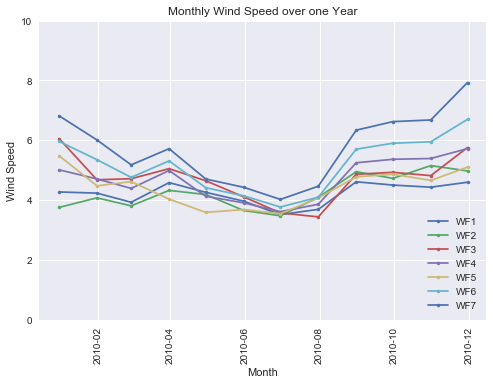

In [13]:
for key, _ in wf_dict.items():
    monthly_ws = wf_dict[key]['ws']['2010'].resample("M",label='left').mean()
    plt.plot(monthly_ws, marker='.')

plt.xlim(['2009-12-15','2010-12-15'])
plt.legend(('WF1', 'WF2', 'WF3', 'WF4', 'WF5', 'WF6', 'WF7'),loc='lower right') 
plt.xlabel('Month')
plt.xticks(rotation='vertical')
plt.title('Monthly Wind Speed over one Year')
plt.ylim([0,10])
plt.ylabel('Wind Speed')
plt.show()

**** Question: Do wind speeds exhibit any seasonal trends? ****

A visualization of mean wind speeds by month indicates that wind speeds tend to be lower during the summer and higher in the fall (September to December).

##### Histogram of Wind Speed, All Wind Farms

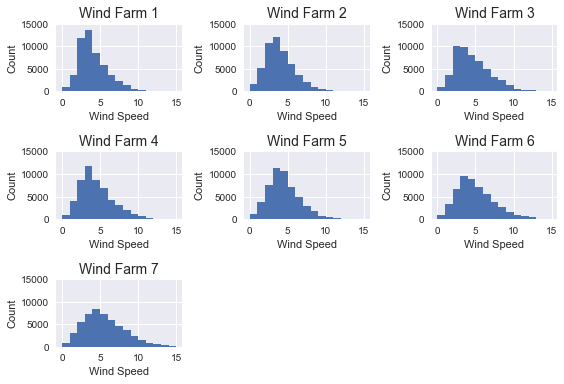

In [14]:
counter = int()
for key, _ in wf_dict.items():
    counter += 1
    plt.subplot(3,3,counter)
    plt.hist(wf_dict[key]['ws'],bins=15, range=(0,15))
    plt.xlabel('Wind Speed')
    plt.ylabel('Count')
    plt.title('Wind Farm ' + str(counter), fontsize=14)
    plt.ylim(0,15000)
plt.tight_layout()
plt.show()

**** Question: Are the distribution of wind speeds different at each wind farm? ****
    
The distributions of wind speeds at all wind farms were unimodal but the shape of the distrubtion was slightly different for each wind farm.  This may be due to geological or other reasons that are not included in the available data. The wind farms are likely independent from each other (the data collected at one wind farm has no effect on the data collected at another wind farm).

##### Hex Plot of Wind Speed versus Wind Direction at all Wind Farms

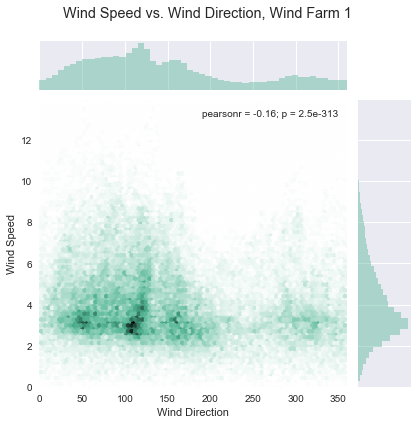

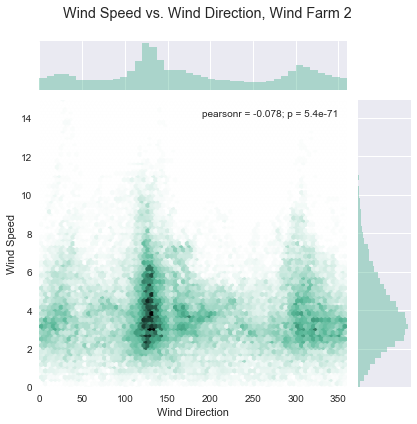

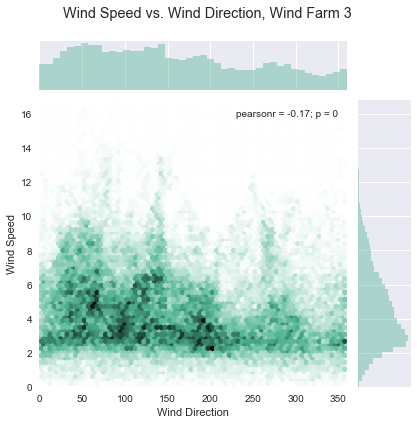

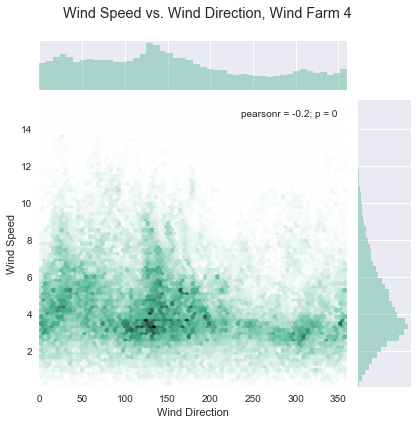

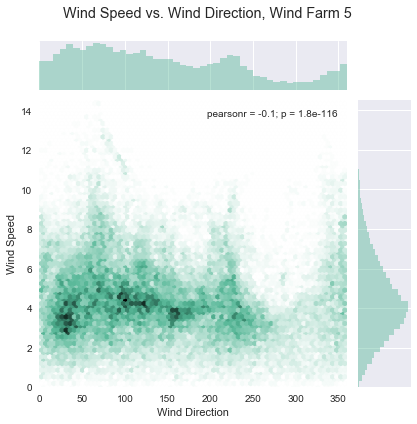

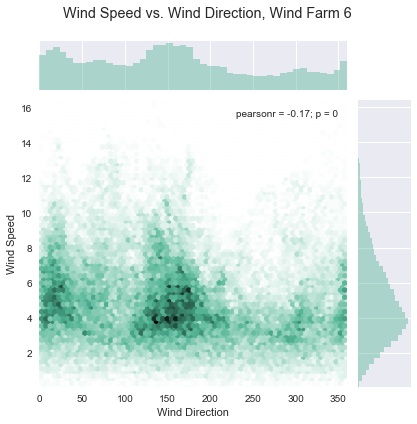

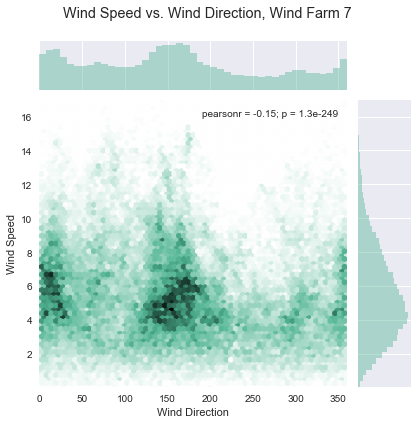

In [15]:
counter = int()
for key, _ in wf_dict.items():
    counter += 1
    hex = sns.jointplot(x='wd', y='ws', data=wf_dict[key], kind='hex', color="#4CB391").set_axis_labels('Wind Direction', 'Wind Speed')
    hex.fig.subplots_adjust(top=0.9)
    hex.fig.suptitle('Wind Speed vs. Wind Direction, Wind Farm '+ str(counter))
    plt.show()

##### Polar Plot of Wind Speed versus Wind Direction at all Wind Farms

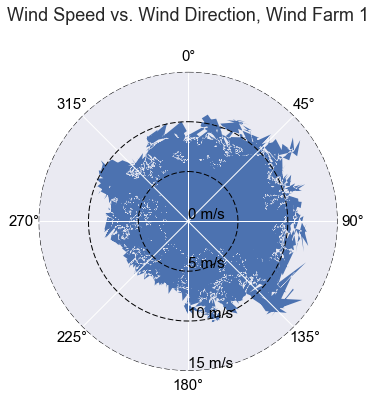

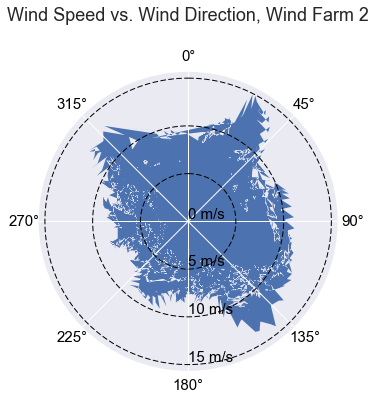

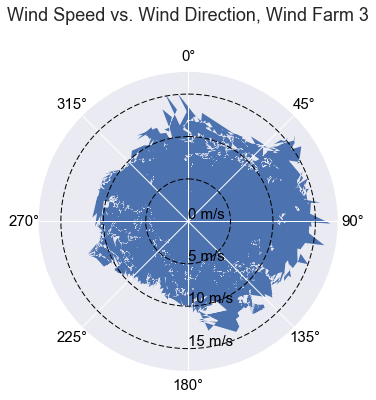

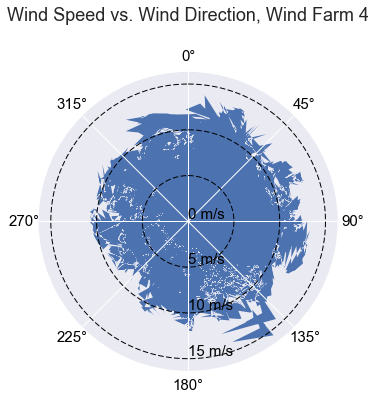

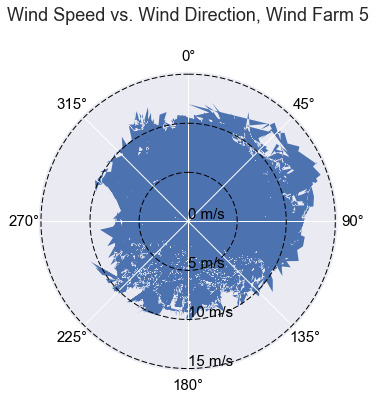

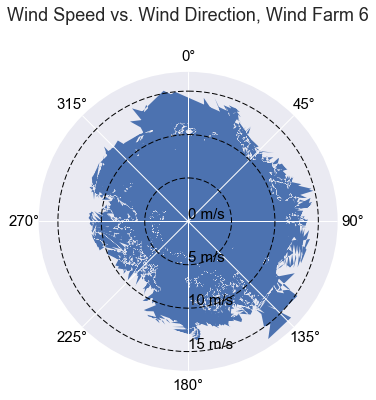

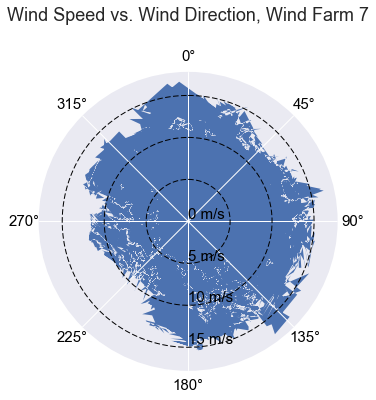

In [16]:
counter = int(0)
for key, _ in wf_dict.items():
    counter +=1 
    ax = plt.subplot(111, projection='polar')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.fill_between([np.pi*x/180 for x in wf_dict[key]['wd']], wf_dict[key]['ws'], 0, zorder=0)
    ax.set_rticks([0, 5, 10, 15])  # less radial ticks
    ax.set_rlabel_position(180)  
    ax.tick_params(direction='out', length=6, width=2, colors='k')
    plt.xticks(size=15)
    plt.yticks(size=15)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{} m/s'.format(y) for y in vals])
    ax.grid(True, which='major', axis='y', color="k", linewidth=1, zorder=1, linestyle='--')
    ax.set_title("Wind Speed vs. Wind Direction, Wind Farm " + str(counter), size=18, y=1.15)
    plt.show()

**** Question: Is there a correlation between wind speed and direction? ****

Across all wind farms, there was either no or weak correlation between wind speed and direction. Some wind farms had concentrated winds in one particular direction (Wind Farm 1, Wind Farm 4) whereas other wind farms had concentrated winds in two directions (Wind Farm 2, Wind Farm 6, Wind Farm 7). Wind Farm 3 and Wind Farm 5 had more winds from 0-250 degrees and less wind from 250-360 degrees.

These differences in distributions may be due to geological or other reasons that are not included in the available data. The wind farms are likely independent from each other (the data collected at one wind farm has no effect on the data collected at another wind farm).

##### Hex Plot of Wind Speed versus Power at all Wind Farms

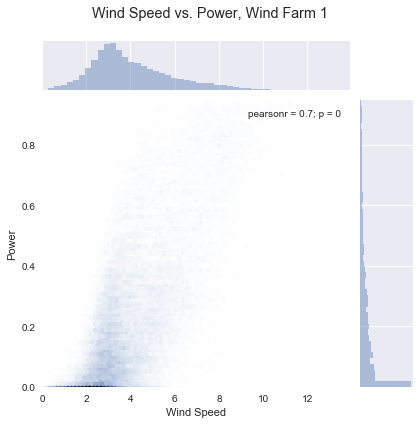

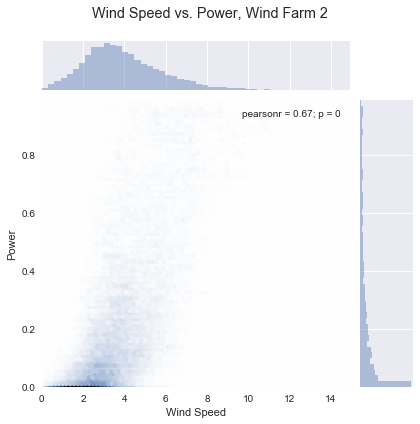

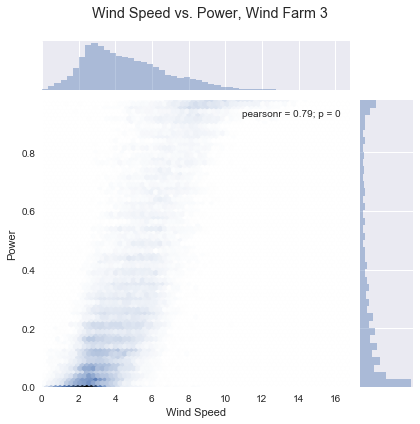

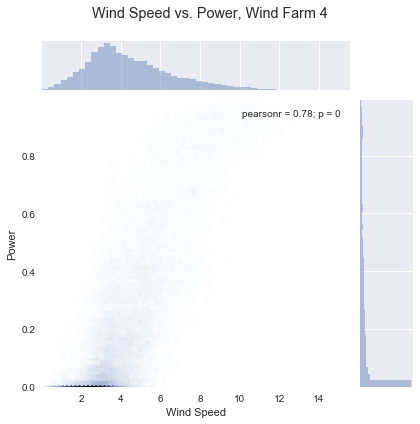

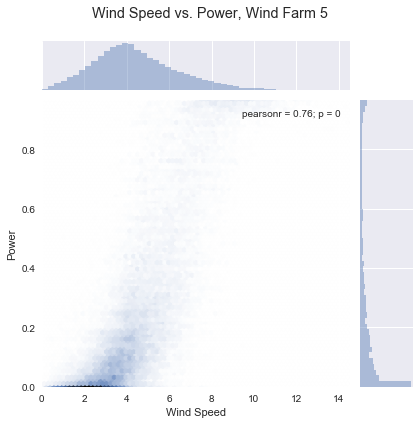

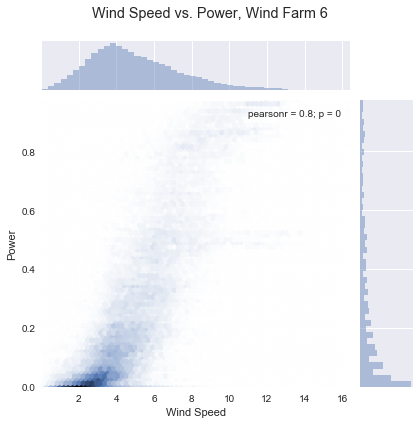

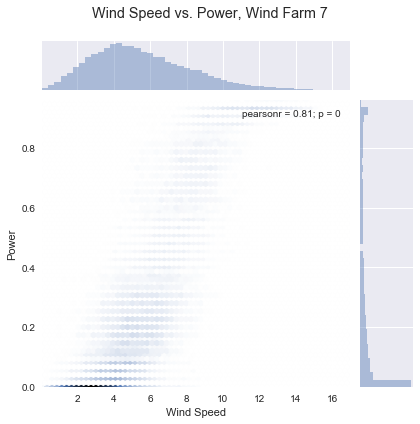

In [17]:
counter = int()
for key, _ in wf_dict.items():
    counter += 1
    hex = sns.jointplot(x='ws', y=wp_lookup[key], data=wf_dict[key], kind='hex').set_axis_labels('Wind Speed', 'Power')
    hex.fig.subplots_adjust(top=0.9)
    hex.fig.suptitle('Wind Speed vs. Power, Wind Farm ' + str(counter))
plt.show()

**** Question: Is wind speed correlated with power? ****

Across all wind farms, there was a strong correlation between wind speed and power, with Pearon's r-values ranging from 0.67-0.81. This correlation is expected given that the theoretical power output of a wind turbine generator is proportional to the cube of the wind speed.  

##### Hex Plot of Wind Direction versus Power at all Wind Farms

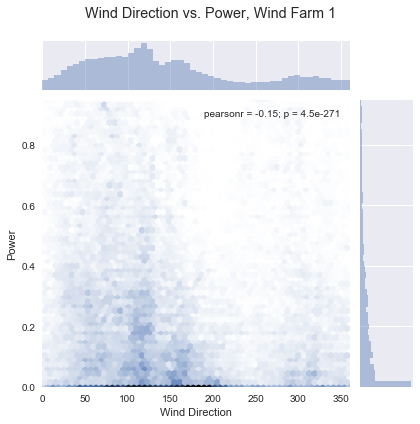

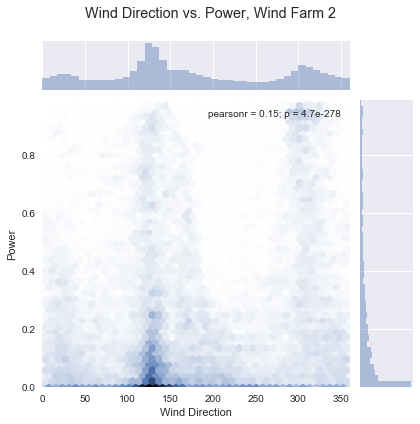

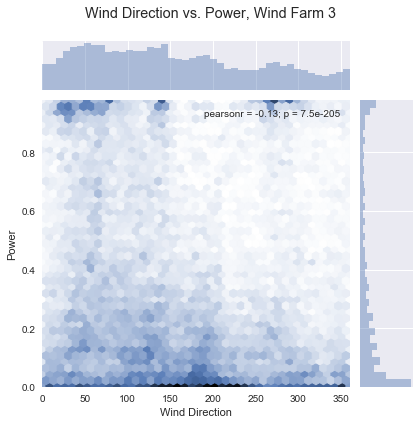

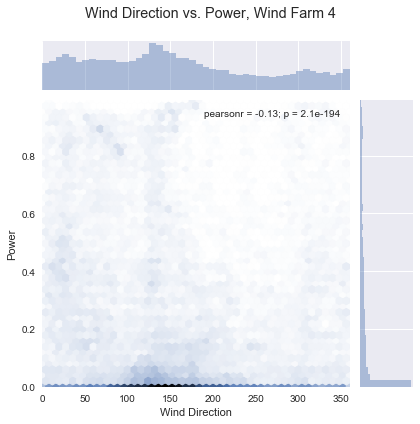

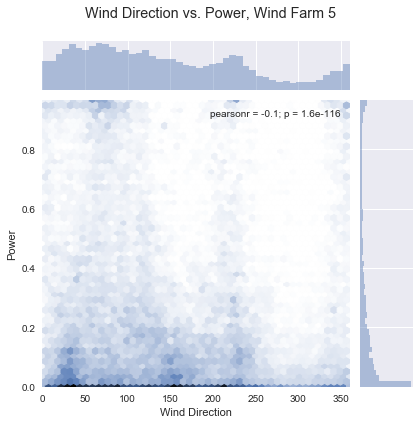

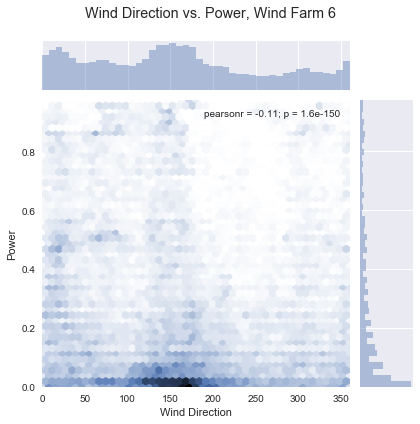

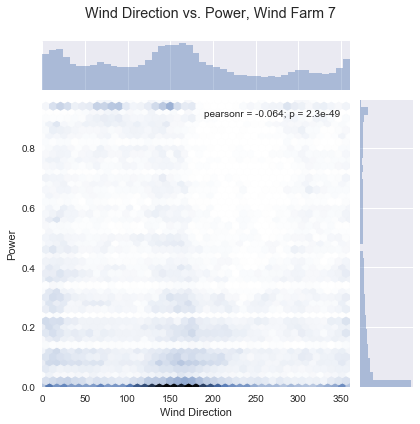

In [18]:
counter = int()
for key, _ in wf_dict.items():
    counter += 1
    hex = sns.jointplot(x='wd', y=wp_lookup[key], data=wf_dict[key], kind='hex').set_axis_labels('Wind Direction', 'Power')
    hex.fig.subplots_adjust(top=0.9)
    hex.fig.suptitle('Wind Direction vs. Power, Wind Farm ' + str(counter))
plt.show()

**** Question: Is wind direction correlated with power? ****

Across all wind farms, there was a no correlation between wind direction and power. 